In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/aug_train.csv')

In [14]:
#데이터 탐색
print(train.shape,'\n')
print(train.head(3),'\n')
print(train.info(),'\n')
print(train.describe(),'\n')
print(train.isnull().sum())

(19158, 14) 

   enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   

  major_discipline experience company_size company_type last_new_job  \
0             STEM        >20          NaN          NaN            1   
1             STEM         15        50-99      Pvt Ltd           >4   
2             STEM          5          NaN          NaN        never   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data 

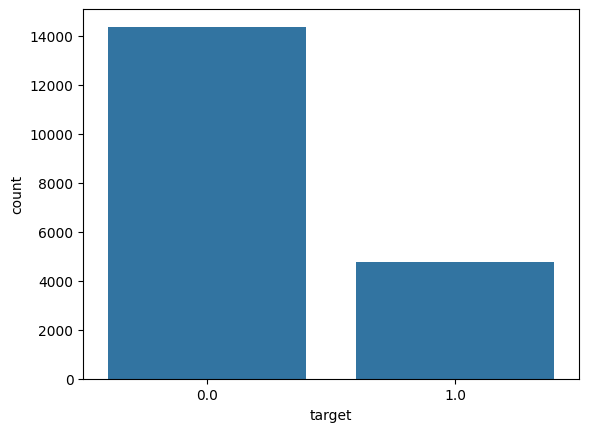

In [4]:
#이직 비율 확인
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data = train, x = 'target')
plt.show()

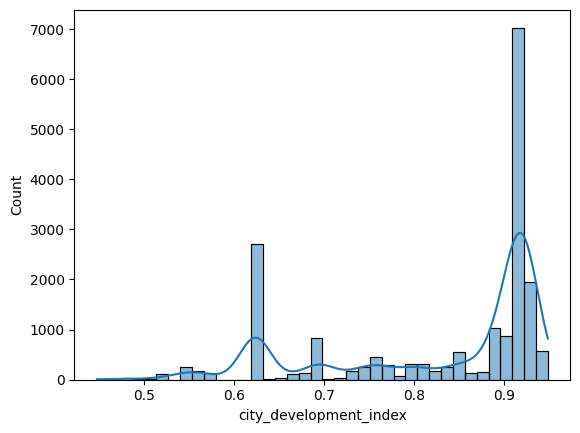

In [5]:
#도시의 개발 지표에 관한 이직분포
sns.histplot(data = train, x = 'city_development_index', kde = True)
plt.show()

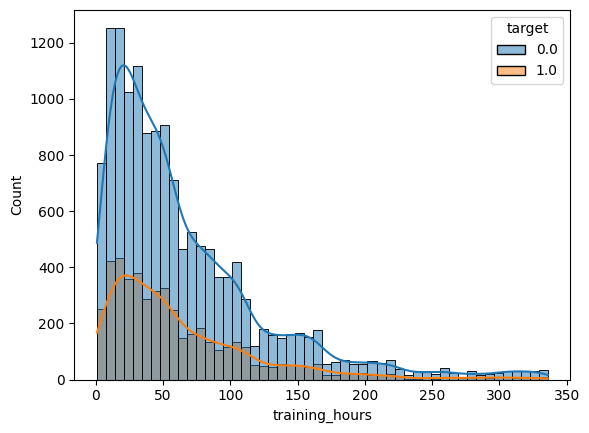

In [6]:
# 이수한 교육시간별 이직분포
sns.histplot(data = train, x = 'training_hours', hue = 'target', bins = 50, kde = True)
plt.show()

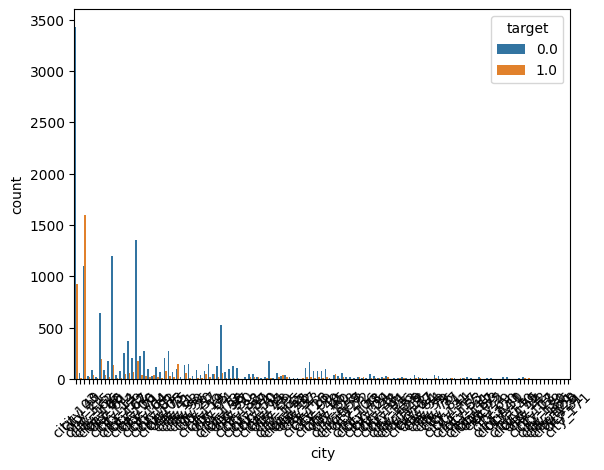

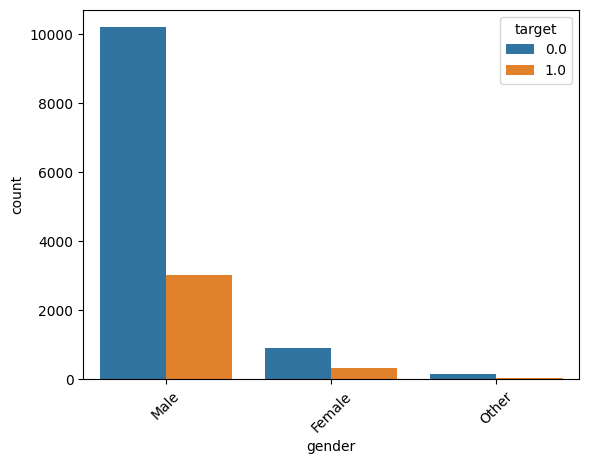

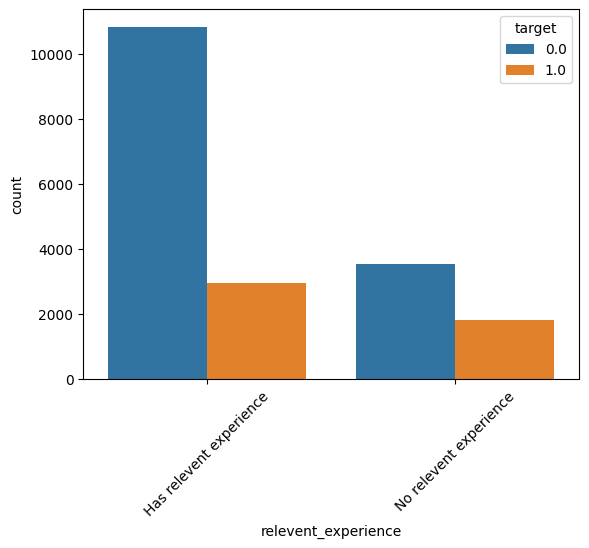

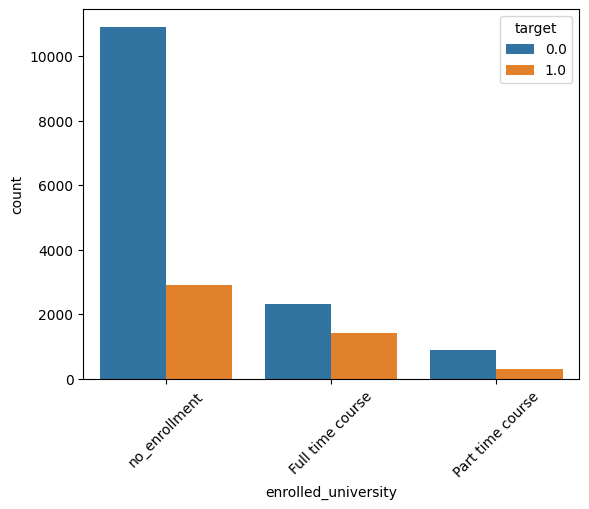

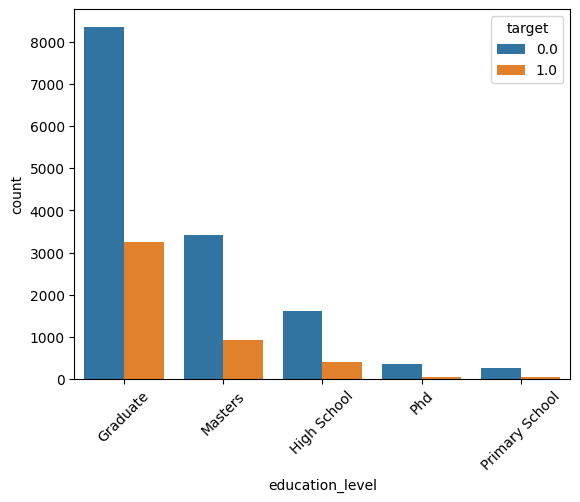

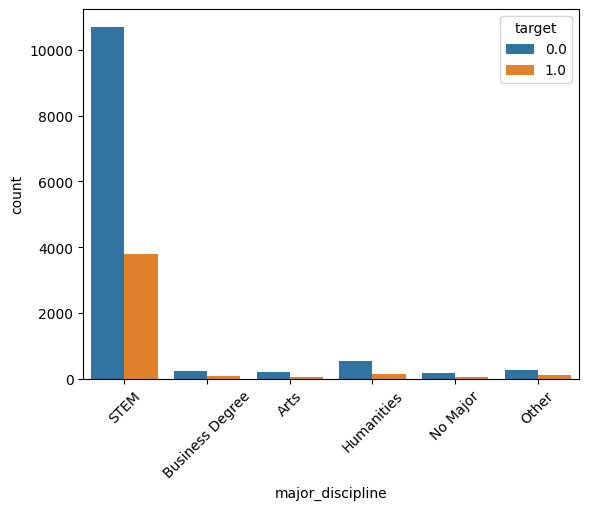

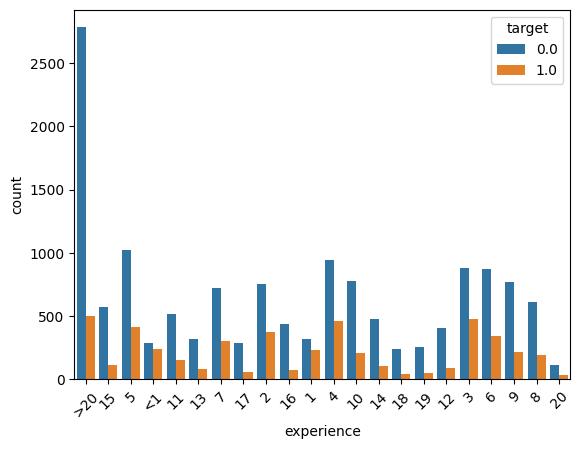

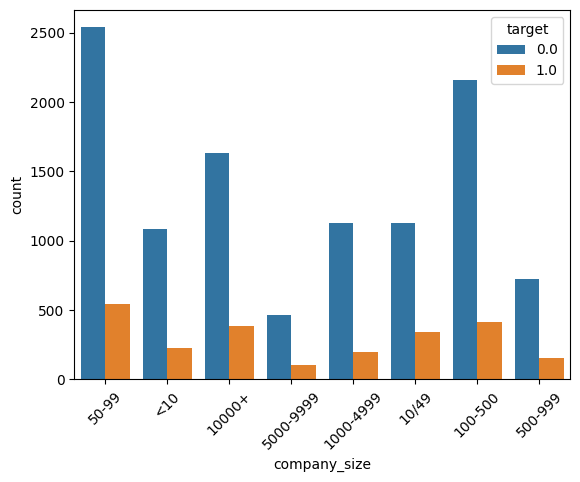

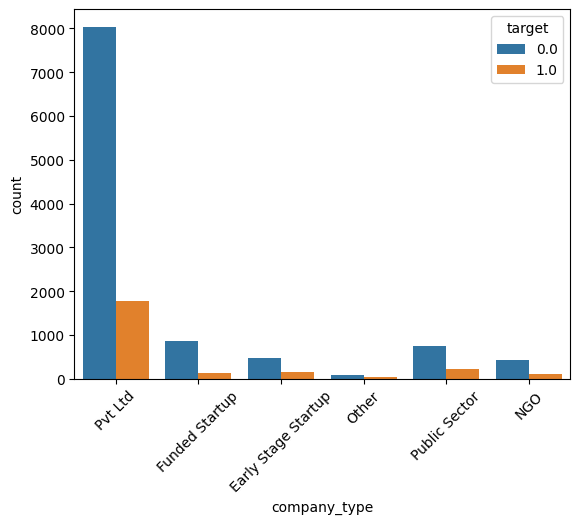

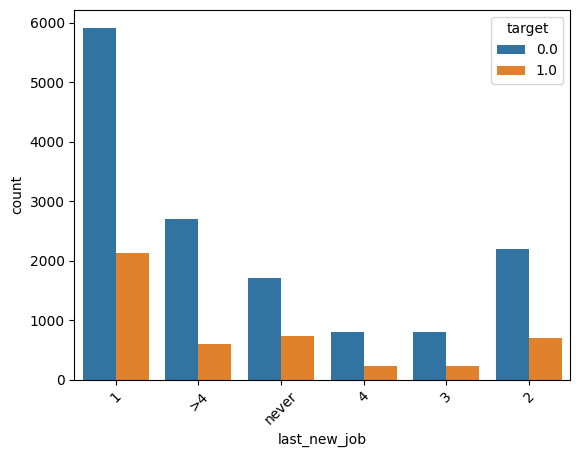

In [7]:
#각 변수마다의 종속변수값의 분포
for col in train.select_dtypes(include='object').columns:
  sns.countplot(data = train, x = col, hue= 'target')
  plt.xticks(rotation = 45)
  plt.show()

In [8]:
#결측치가 있는 변수들
nan_col = []
for col in train.columns:
  if train[col].isnull().sum() != 0:
    nan_col.append(col)
nan_col

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [9]:
#결측치는 최빈값으로 채움
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
train[nan_col] = imputer.fit_transform(train[nan_col])

In [10]:
x = train.drop(['enrollee_id', 'target'],axis=1)
y = train.target

In [15]:
#변수구성
for col in x.select_dtypes(include='object').columns:
  print(col)
  print(train[col].unique(),'\n')

city
['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_79' 'city_76'
 'city_77' 'city_81' 'city_131' 'city_44' 'city

In [16]:
#종속변수 데이터 스케일링
le_col = x.select_dtypes(include='object').columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in le_col:
  x[col] = le.fit_transform(x[col])

In [17]:
#수치형 데이터 스케일링
mms_col = x.select_dtypes(exclude='object').columns
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

x[mms_col] = mms.fit_transform(x[mms_col])

In [18]:
#데이터 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y,random_state=88)

In [19]:
#최적의 파라미터 찾기
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
params = {'n_estimators':range(5,20), 'max_depth': range(2,10)}
gscv = GridSearchCV(estimator=rf, param_grid=params, cv=5)
gscv.fit(x_train, y_train)
print(gscv.best_params_)

{'max_depth': 9, 'n_estimators': 16}


In [20]:
#모델 생성 및 예측
model = RandomForestClassifier(max_depth=9, n_estimators=16, random_state=88)
model = rf.fit(x_train,y_train)
pred = model.predict(x_test)

In [21]:
#모델 정확도
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('accuracy score:', round(accuracy_score(y_test, pred),2))
print('confusion maxtirx:', '\n',confusion_matrix(y_test,pred))
print('report:', '\n',classification_report(y_test,pred))

accuracy score: 0.76
confusion maxtirx: 
 [[2550  327]
 [ 586  369]]
report: 
               precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      2877
         1.0       0.53      0.39      0.45       955

    accuracy                           0.76      3832
   macro avg       0.67      0.64      0.65      3832
weighted avg       0.74      0.76      0.75      3832



In [22]:
#종속변수(이직)에 주는 영향
feature_importance = pd.DataFrame({'features':x_train.columns, 'importances':model.feature_importances_})
print(feature_importance)

                  features  importances
0                     city     0.102245
1   city_development_index     0.175216
2                   gender     0.018391
3      relevent_experience     0.020583
4      enrolled_university     0.030253
5          education_level     0.038981
6         major_discipline     0.023635
7               experience     0.147802
8             company_size     0.073458
9             company_type     0.028902
10            last_new_job     0.068610
11          training_hours     0.271922


<Axes: xlabel='importances', ylabel='features'>

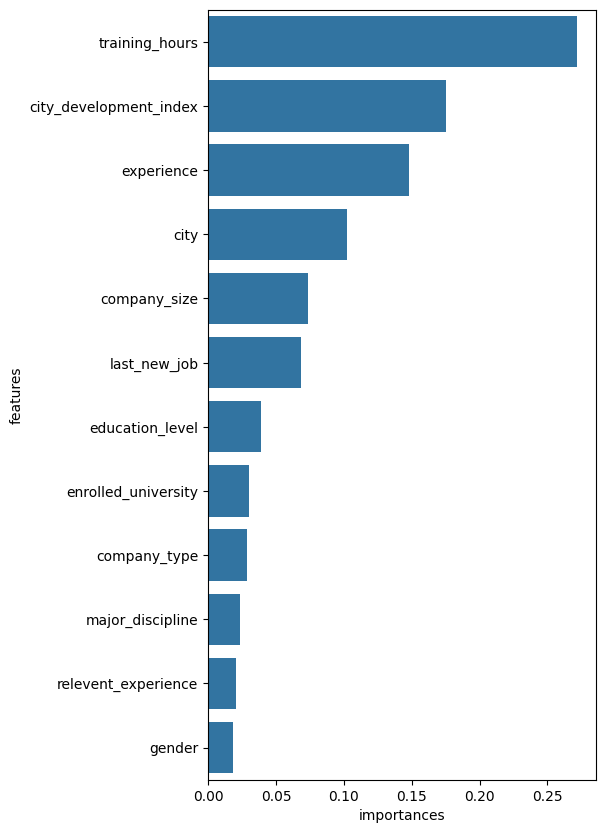

In [23]:
#시각화
plt.figure(figsize=(5,10))
sns.barplot(x='importances', y='features', data=feature_importance.sort_values('importances', ascending=False))
